# Quick Demo
I'll use this doc to briefly demo the code. The core functionality to fit the GP and evaluate the log-likelihood is just four lines of code (3 lines to train the GP, 1 lines to calculate the likelihood or RMSE etc). Of course we need to load the libraries, data, grids, do plots, print results etc, so that what the rest of the code here is doing.

Let's begin by loading the libraries we'll need.

In [1]:
import GPy
import sys
import os
 
module_dir = os.getenv("HOME")+'/Documents/Code/ModelDataComparison_clean/'
sys.path.append(module_dir+"/core/")
from HaversineDist import Exponentialhaversine
import numpy as np
%matplotlib inline
from mpl_toolkits.basemap import Basemap
# If you don't have Basemap installed - comment out this line and use
import matplotlib.pyplot as plt
import matplotlib
import glob as glob
from cmocean import cm as cm
from Utilities import *
from score import *

Now let's specify where the data and model runs are located, and load them.

In [2]:
GCM_dir = module_dir+'data/Model_data/CO2_anom/'
obs_dir = module_dir +'data/Observation_data/P3+_SST_anom/'


gcm_SSTs = glob.glob(GCM_dir+'t*.txt')
gcm_mask = np.genfromtxt(GCM_dir+'mask.txt', dtype='int')
file = 'lambda_10.txt'
observations = np.genfromtxt(obs_dir+file, skip_header=1)

We'll extract the observations into their coordinates (long and lat) which I'll refer to as X, the measurement (Y), and our estimate of the ratio of the variance of the measurement error at each point (NOTE: I was unsure whether the numbers in the data you gave me were supposed to standard deviations or variances - they look like std devs, so I've squared them). Note that all that matters is the relative size of these variances (their ratio). We need to try changing this to find its effect.

I've plotted the locations just as a check.

In [5]:
X_obs = observations[:,0:2]
y_obs = observations[:,2].reshape(-1,1)
var_ratios = observations[:,3][:,None]**2
map = plot_map(X_obs=X_obs, basemap=False)


Need basemap to plot just the points


## Fitting a Gaussian process model



In [6]:

from scaledheteroscedasticgaussian import ScaledHeteroscedasticGaussian
from gp_heteroscedastic_ratios import ScaledHeteroscedasticRegression


k3 = Exponentialhaversine(2, lengthscale=2000)
m3 = ScaledHeteroscedasticRegression(X=X_obs, Y=y_obs, kernel=k3, noise_mult=1., 
                                     known_variances=var_ratios)
m3.optimize_restarts(10)


Warning - ARD must be False at the moment
Optimization restart 1/10, f = 202.7394228954263


 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/paramz/transformations.py:109: RuntimeWarning:overflow encountered in expm1


Optimization restart 2/10, f = 256.5356750830574
Optimization restart 3/10, f = 230.2914880667802
Optimization restart 4/10, f = 230.29148814108314
Optimization restart 5/10, f = 256.53567604073555
Optimization restart 6/10, f = 230.29148806663554
Optimization restart 7/10, f = 256.53567622356434
Optimization restart 8/10, f = 256.5356760512533
Optimization restart 9/10, f = 230.2914880675463
Optimization restart 10/10, f = 256.53567471957234


Note that the fitting the GP is just three lines of code. We can visualise the model fit by predicting on a grid.


Name : gp
Objective : 202.7394228954263
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  gp.                          |          value  |  constraints  |  priors
  Exponential.variance         |  9.72822417707  |      +ve      |        
  Exponential.lengthscale      |  4778.83030186  |      +ve      |        
  Scaled_het_Gauss.noise_mult  |  7.99632407141  |      +ve      |        


 /Users/pmzrdw/Documents/Code/ModelDataComparison_clean//core/Utilities.py:83: FutureWarning:comparison to `None` will result in an elementwise object comparison in the future.
 /Users/pmzrdw/Documents/Code/ModelDataComparison_clean//core/Utilities.py:114: FutureWarning:comparison to `None` will result in an elementwise object comparison in the future.


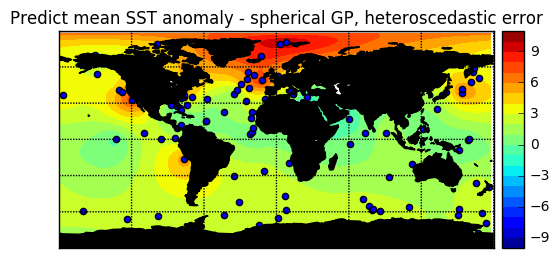

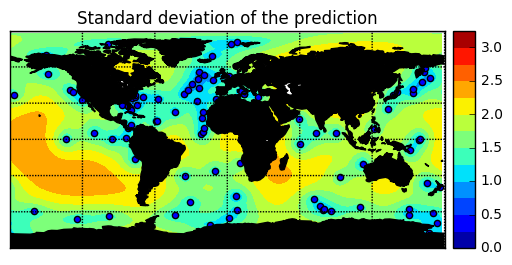

In [17]:
print(m3)
latsplot = np.arange(-90.0,90.0, 2.5)
longsplot = np.arange(-180.0,180.0, 2.5)
longgridplot, latgridplot = np.meshgrid(longsplot, latsplot)
X_plot=np.column_stack((longgridplot.flatten(), latgridplot.flatten())) # specifies the prediction locations

mu3,V3 = m3.predict_noiseless(X_plot)


plt.figure(3)
map=plot_map(longgridplot, latgridplot, mu3, X_obs, basemap=True)
plt.title('Predict mean SST anomaly - spherical GP, heteroscedastic error')

plt.figure(4)
map=plot_map(longgridplot, latgridplot, np.sqrt(V3), X_obs, levels=np.arange(0,np.sqrt(V3).max()+1,0.25))
plt.title('Standard deviation of the prediction')

## Likelihood calculations

Let's now evaluate the 8 GCM simulations we have available. To do this, we need to predict the GCM output at every grid cell, and then evalaute the probability of seeing this value under our GP model fitted to the observational data.

We'll begin by loading the GCM runs, and then thinning them onto a coarser grid.

In [18]:
thinby=2 # this controls the degree of thinning.
# thinby=2 takes every second value
# thinby=1 uses the original GCM grid. This is fine on my laptop (takes about 10 mins), 
# but my desktop runs out of memory before it completes.

count=0
gcm_runs = np.zeros((8,27186))
gcm_runs_label = gcm_SSTs.copy()

for file_name in gcm_SSTs:
    file_nm = file_name.split(GCM_dir)[-1]
    print(file_nm)
    # Read in GCM output.
    gcm_runs[count,:] = np.genfromtxt(file_name)
    gcm_runs_label[count] = file_nm.split(".txt")[0]
    count +=1


# Create the prediction grid - removing the land coordinates to save computation effort.
tmp1, tmp2 = ThinGrid(gcm_runs[0,:], gcm_mask, thinby=thinby) # just to get size
gcm_thin = np.zeros((8, tmp2.size))
for count in range(8):
    X_pred, out = ThinGrid(gcm_runs[count,:], gcm_mask, thinby=thinby)
    gcm_thin[count,:] = out.flatten()


tczyi.txt
tczyj.txt
tczyk.txt
tdgtg.txt
tdgth.txt
tdgti.txt
tdgtj.txt
tdgtk.txt


I've now wrapped the different scoring approaches we considered in the function called 'score'. You have to tell it the method you want to use. The default is to use the GP mean and variance to calculate a loglikelihood, ignoring the covariance. To see the options, type

In [19]:
score?

In [20]:
loglikes_var_only, orderings_var_only, relative_var_only =score(X_pred, gcm_thin, X_obs, y_obs, m3,method = 'gp_var')
loglikes_full, orderings_full, relative_full =score(X_pred, gcm_thin, X_obs, y_obs, m3,method = 'gp_full_cov')
loglikes_mean, orderings_mean, relative_mean =score(X_pred, gcm_thin, X_obs, y_obs, m3,method = 'gp_mean')




Note that the likelihood calculation is just three lines, but I've wrapped it here. See earlier versions of this notebook, or the code to see the details.

We can decode from the file names to the CO2 values to this to see how this ranks the various GCM runs.

In [ ]:
dict = {'tdgth': '280 ppm',
        'tczyi': '315 ppm',
    'tdgtj': '350 ppm',
    'tczyj': '375 ppm',
    'tdgtg': '405 ppm',
    'tczyk': '475 ppm',
    'tdgtk': '560 ppm',
    'tdgti': '1000 ppm'}

orderings = orderings_var_only
relative = relative_var_only

for ii in range(8):
    print(dict[gcm_runs_label[orderings[ii]]] + ':  relative loglike = '+str(relative[orderings[ii]]))

We can compare this with the ranking we obtain using the RMSE as a score function. 

In [ ]:
RMSEs, _, _ =score(X_pred, gcm_thin, X_obs, y_obs, None, method = 'RMSE')
print(RMSEs)

In [ ]:
CO2 = np.zeros(8)
for ii in range(8):
    CO2[ii] = int(dict[gcm_runs_label[ii]].split(' ppm')[0])
    
plt.scatter(CO2, -RMSEs)

plt.title('-RMSE vs pCO2')

In [ ]:
plt.figure()
plt.scatter(CO2, loglikes_var_only)
plt.title('log-likelihood (var only) vs pCO2')

plt.figure()
plt.scatter(CO2, loglikes_full)
plt.title('log-likelihood (full cov) vs pCO2')

plt.figure()
plt.scatter(CO2, -loglikes_mean)
plt.title('-RMSE using GP mean on grid vs pCO2')

In [ ]:


CS = plot_gcm(gcm_runs[orderings[ii],:], gcm_mask, X_obs=X_obs, basemap=True)
plt.show()


plot_gcm(gcm_runs[orderings[ii],:], gcm_mask, X_obs=X_obs, basemap=False)